In [1]:
import os
import pickle

import numpy as np
import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from policy import config
from policy.dataset.dataset_loaders import dataset_loader
from policy.checkpoints import CheckpointIO

model_dir = "/home/mrl/Documents/Projects/tskill/out/PegInsertion/Plan/004"

cfg_path = os.path.join(model_dir, "config.yaml")
cfg = config.load_config(cfg_path, None)
method = cfg["method"]
if method == "plan":
    cfg["vae_cfg"] = config.load_config(os.path.join(cfg["model"]["vae_path"],"config.yaml"))

# index_path = os.path.join(model_dir, "data_info.pickle")
# with open(index_path, 'rb') as f:
#     data_info = pickle.load(f)

# # Dataset
cfg["data"]["pad"] = False
cfg["data"]["augment"] = False
cfg["data"]["full_seq"] = False
cfg["data"]["mode"] = "libero"
# cfg["data"]["dataset"] = ["/home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/LIVING_ROOM_SCENE1_pick_up_the_tomato_sauce_and_put_it_in_the_basket_demo.hdf5",
#                           "/home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/KITCHEN_SCENE1_open_the_top_drawer_of_the_cabinet_and_put_the_bowl_in_it_demo.hdf5"]
cfg["data"]["dataset"] = "/home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90"
# cfg["data"]["mode"] = "maniskill"
# cfg["data"]["dataset"] = "/home/mrl/Documents/Projects/tskill/data/demos/v0/rigid_body/PegInsertionSide-v0/trajectory.rgbd.pd_joint_delta_pos2.h5"

# Load only the full episode version of the dataset
# if "train_ep_indices" not in data_info.keys():
#     train_idx, val_idx = data_info["train_indices"], data_info["val_indices"]
# else:
#     train_idx, val_idx = data_info["train_ep_indices"], data_info["val_ep_indices"]
train_dataset, val_dataset = dataset_loader(cfg, return_datasets=True)

# Model
# model = config.get_model(cfg, device="cpu")
# checkpoint_io = CheckpointIO(model_dir, model=model)
# load_dict = checkpoint_io.load("model_best.pt")
# model.train()

/home/mrl/miniconda3/envs/tskill/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Found existing multitask data info file
>>> Loading multitask dataset from file: out/PegInsertion/Plan/004/data_info.pickle
Loading dataset: /home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/KITCHEN_SCENE6_close_the_microwave_demo.hdf5
Loading indices from file: out/PegInsertion/Plan/004/data_info.pickle
Adding batch dimension to returned data!
Loading dataset: /home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/LIVING_ROOM_SCENE6_put_the_chocolate_pudding_to_the_left_of_the_plate_demo.hdf5
Loading indices from file: out/PegInsertion/Plan/004/data_info.pickle
Adding batch dimension to returned data!
Loading dataset: /home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/KITCHEN_SCENE10_close_the_top_drawer_of_the_cabinet_demo.hdf5
Loading indices from file: out/PegInsertion/Plan/004/data_info.pickle
Adding batch dimension to returned data!
Loading dataset: /home/mrl/Documents/Projects/tskill/LIBERO/libero/datasets/libero_90/KITCHEN_SCEN

4050


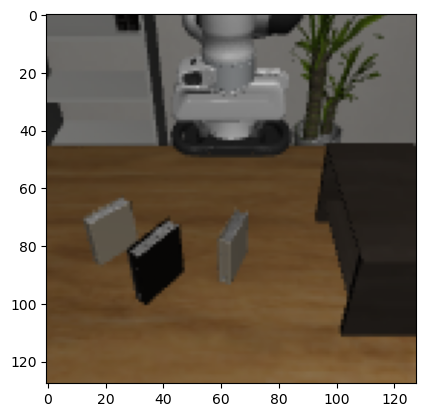

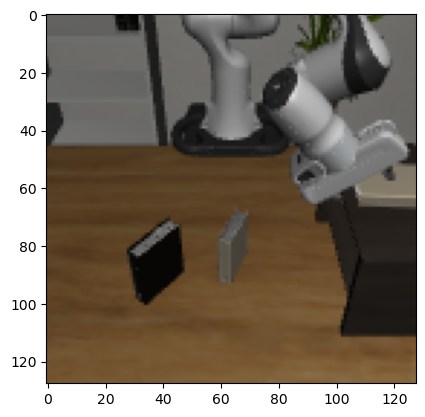

In [5]:
import time
print(len(train_dataset))
# for i in range(len(train_dataset)):
#     print([(k,v.shape) for k,v in train_dataset[i].items()])
i = torch.randint(0, len(train_dataset), (1,1)).item()
j = 5
plt.imshow(train_dataset[i]["rgb"][0,j,0,:,:,:].permute(1,2,0))
plt.show()
# plt.imshow(train_dataset[5]["rgb"][0,5,1,:,:,:].permute(1,2,0))
plt.imshow(train_dataset[i]["goal"][0,0,0,:,:,:].permute(1,2,0))
plt.show()
time.sleep(0.1)
plt.close()

In [2]:
train = True
if not train:
    dataset = val_dataset
    print("Using Validation Dataset")
    idxs = val_idx
else:
    dataset = train_dataset
    print("Using Training Dataset")
    idxs = train_idx

i = 1
data = dataset[i]
# with torch.no_grad():
data = {k: torch.vstack((v,v)) for k,v in data.items()}
data["seq_pad_mask"][0,...] = torch.ones_like(data["seq_pad_mask"][0,...])
data["skill_pad_mask"][0,...] = torch.ones_like(data["skill_pad_mask"][0,...])
print(data["seq_pad_mask"].shape)
model.zero_grad()
out = model(data)
print(f"==>> out: {out}")

Using Training Dataset
torch.Size([2, 152])
==>> batch_mask: tensor([False,  True])
==>> out: {'a_hat': tensor([[[-0.5221,  0.1630, -0.9107,  ...,  0.1944,  0.3796,  0.9750],
         [-0.5171, -0.0427, -0.8406,  ...,  0.3647,  0.2453,  0.9784],
         [-0.4795,  0.1366, -0.9926,  ...,  0.4508,  0.5319,  0.9671],
         ...,
         [ 0.7082,  0.6392,  0.4021,  ..., -0.9295,  0.6603, -0.9849],
         [ 0.5679,  0.6016,  0.6472,  ..., -0.6540,  0.4302, -0.9721],
         [ 0.6214,  0.4352,  0.6776,  ..., -0.6956,  0.4620, -0.9791]],

        [[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]]],
       grad_